In [1]:
import numpy as np
import pandas as pd
from quantbullet.preprocessing import FlatRampTransformer
from sklearn.preprocessing import OneHotEncoder
from quantbullet.linear_product_model import LinearProductModelToolkit, LinearProductRegressorBCD
from quantbullet.parametric_model import AsymQuadModel, InterpolatedModel
from quantbullet.parametric_model.utils import compare_models
from quantbullet.linear_product_model.datacontainer import ProductModelDataContainer
from quantbullet.model.feature import DataType, Feature, FeatureRole, FeatureSpec

In [2]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos( df['x1'] / 3 ) + np.sin(df['x2'] / 5) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

preprocess_config = {
    'x1': FlatRampTransformer(
        knots = list( np.arange( 4, 16, 1 ) ),
        include_bias=True
    ),
    'x2': FlatRampTransformer(
        knots = list( np.arange( 14, 26, 1 ) ),
        include_bias=True
    ),
    'x3': OneHotEncoder( drop=None )
}

feature_spec = FeatureSpec(
    [
        Feature( name = 'x1', dtype = DataType.FLOAT, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'x2', dtype = DataType.FLOAT, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'x3', dtype = DataType.CATEGORY, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'y', dtype = DataType.FLOAT, role = FeatureRole.TARGET )
    ]
)

tk = LinearProductModelToolkit( feature_spec=feature_spec, preprocess_config=preprocess_config ).fit( df )
expanded_df = tk.get_expanded_df( df )

In [3]:
dcontainer = ProductModelDataContainer( df, expanded_df, response=df['y'], feature_groups=tk.feature_groups )

In [4]:
model = LinearProductRegressorBCD()
model.fit( dcontainer, feature_groups=tk.feature_groups, n_iterations=20, early_stopping_rounds=5, cache_qr_decomp=False, ftol=1e-8, offset_y=0 )

Iteration 1/20, Loss: 5.025260e-01
Iteration 2/20, Loss: 5.015175e-01
Iteration 3/20, Loss: 5.015175e-01
Iteration 4/20, Loss: 5.015175e-01
Iteration 5/20, Loss: 5.015175e-01
Iteration 6/20, Loss: 5.015175e-01
Iteration 7/20, Loss: 5.015175e-01
Converged at iteration 7 with Loss: 5.0152e-01


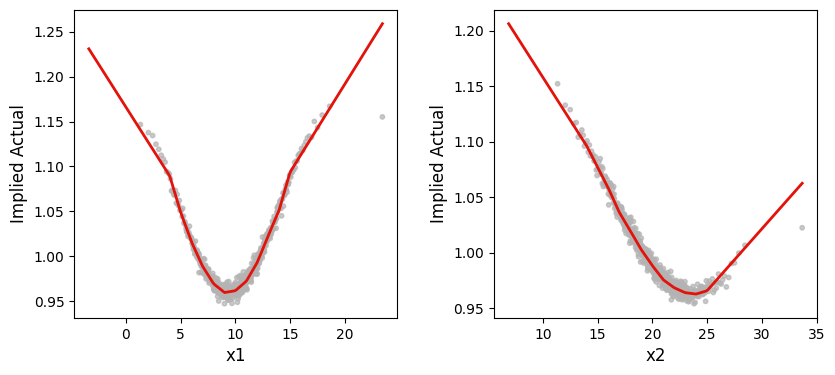

In [5]:
fig, axes = tk.plot_implied_actuals( model, dcontainer, sample_frac=1, n_quantile_groups=500 )

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

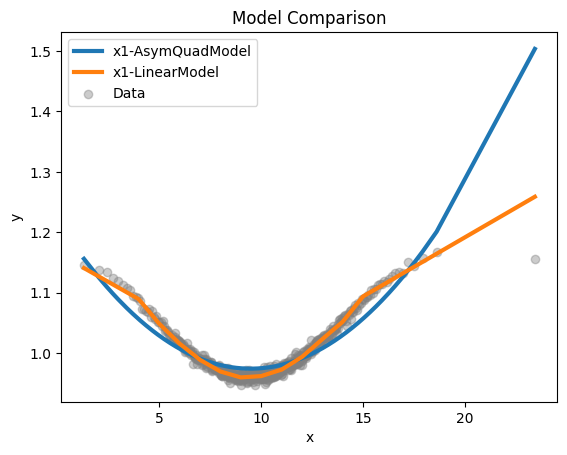

In [6]:
feature_name = 'x1'
cache = tk.get_implied_actual_caches( feature_name)
linear_model_pred = cache.bin_model_preds
x = cache.bin_right
implied_actuals = cache.bin_implied_actuals

x1_model = AsymQuadModel( allow_extrapolation=False ).fit( x, implied_actuals )
x1_model.model_name = "x1-AsymQuadModel"

linear_model = InterpolatedModel().fit( x, linear_model_pred )
linear_model.model_name = "x1-LinearModel"

compare_models( models=[x1_model, linear_model], x=x, y=implied_actuals )

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

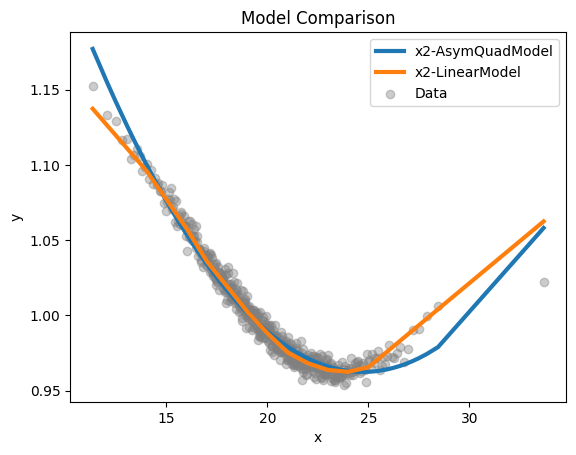

In [7]:
feature_name = 'x2'
cache = tk.get_implied_actual_caches( feature_name)
linear_model_pred = cache.bin_model_preds
x = cache.bin_right
implied_actuals = cache.bin_implied_actuals

x1_model = AsymQuadModel( allow_extrapolation=False ).fit( x, implied_actuals )
x1_model.model_name = "x2-AsymQuadModel"

linear_model = InterpolatedModel().fit( x, linear_model_pred )
linear_model.model_name = "x2-LinearModel"

compare_models( models=[x1_model, linear_model], x=x, y=implied_actuals )

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x3', ylabel='Implied Actual'>, <Axes: >, <Axes: >],
       dtype=object))

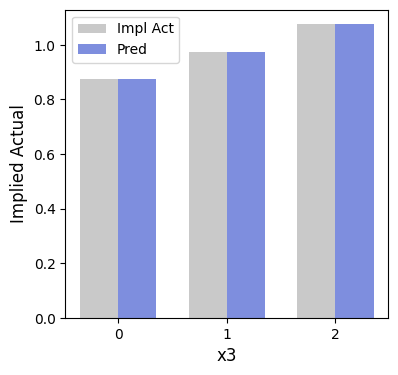

In [8]:
tk.plot_categorical_plots( model, dcontainer, sample_frac=1 )

## Use Parametric Models as Model Components

In [9]:
# from quantbullet.linear_product_model import ComponentManager, ComponentConfig, ComponentRegistry
# x1_component = ComponentConfig(
#     class_name = 'AsymQuadModel',
#     args = x1_model.to_dict(),
# )

# manager = ComponentManager( ComponentRegistry( label='Test' ) )
# manager.add_component( "x1", x1_component )
# manager.to_json( r"test-model-components.json" )

## Test the support for Model Components

In [11]:
import numpy as np
import pandas as pd

from quantbullet.linear_product_model import (
    ComponentManager,
    ComponentConfig,
    ComponentRegistry,
    LinearProductModelToolkit,
    LinearProductRegressorBCD,
)
from quantbullet.linear_product_model.datacontainer import ProductModelDataContainer
from quantbullet.preprocessing import FlatRampTransformer
from quantbullet.parametric_model import AsymQuadModel, InterpolatedModel
from quantbullet.parametric_model.utils import compare_models
from sklearn.preprocessing import OneHotEncoder

In [12]:
component_manager = ComponentManager.from_json( r"./test-model-components.json" )

In [13]:
component_manager.build_all_models()

In [31]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos( df['x1'] / 3 ) + np.sin(df['x2'] / 5) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

preprocess_config = {
    # 'x1': FlatRampTransformer(
    #     knots = list( np.arange( 4, 16, 1 ) ),
    #     include_bias=True
    # ),
    'x2': FlatRampTransformer(
        knots = list( np.arange( 14, 26, 1 ) ),
        include_bias=True
    ),
    'x3': OneHotEncoder( drop=None )
}

feature_spec = FeatureSpec(
    [
        Feature( name = 'x1', dtype = DataType.FLOAT, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'x2', dtype = DataType.FLOAT, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'x3', dtype = DataType.CATEGORY, role = FeatureRole.MODEL_INPUT ),
        Feature( name = 'y', dtype = DataType.FLOAT, role = FeatureRole.TARGET )
    ]
)

tk = LinearProductModelToolkit( feature_spec=feature_spec, preprocess_config=preprocess_config ).fit( df )
expanded_df = tk.get_expanded_df( df )

In [32]:
dcontainer = ProductModelDataContainer( df, expanded_df, response=df['y'], feature_groups=tk.feature_groups )

In [33]:
model = LinearProductRegressorBCD()

In [35]:
model.fit( dcontainer, feature_groups=tk.feature_groups, submodels = component_manager.models, n_iterations=20, early_stopping_rounds=5, cache_qr_decomp=False, ftol=1e-8, offset_y=0 )

Iteration 1/20, Loss: 5.236007e-01
Iteration 2/20, Loss: 5.232408e-01
Iteration 3/20, Loss: 5.232408e-01
Iteration 4/20, Loss: 5.232408e-01
Iteration 5/20, Loss: 5.232408e-01
Iteration 6/20, Loss: 5.232408e-01
Converged at iteration 6 with Loss: 5.2324e-01


(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x1', ylabel='Implied Actual'>,
        <Axes: xlabel='x2', ylabel='Implied Actual'>, <Axes: >],
       dtype=object))

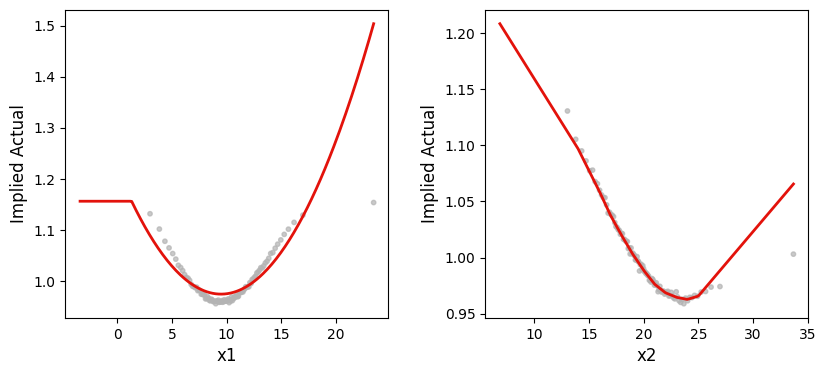

In [36]:
tk.plot_implied_actuals( model, dcontainer )

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x3', ylabel='Implied Actual'>, <Axes: >, <Axes: >],
       dtype=object))

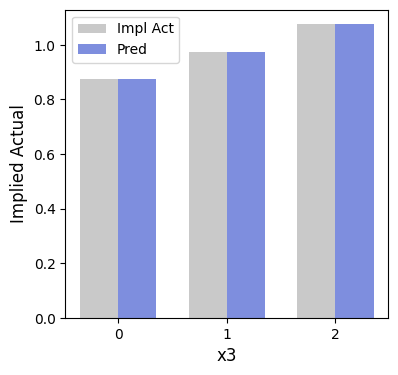

In [37]:
tk.plot_categorical_plots( model, dcontainer )

In [38]:
tk.generate_full_report_pdf( model, report_name=f"debug-report" )

'debug-report-Full.pdf'